In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from math import sqrt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.regularizers import l1 , l2
import tensorflow as tf  
from tensorflow.keras import layers, models, initializers, regularizers
from tensorflow.keras.models import load_model
from scipy.stats import pearsonr
import seaborn as sns
sns.set(style="ticks", font="Times New Roman", font_scale=1.2)
tf.random.set_seed(42)

## Data extracting 

In [8]:

data_path = 'F:/DAS_Downsampling/dataset'
folder_name1 = 'half_hour_merged_good_channels_S_1-2M.csv'
folder_name2 = 'half_hour_merged_good_channels_S_6M.csv'
folder_name3 = 'half_hour_merged_good_channels_S_7M(1).csv'
folder_name4 = 'half_hour_merged_good_channels_S_7M(2).csv'
folder_name5 = 'half_hour_merged_good_channels_S_8M.csv'
folder_name6 = 'NA_AWAC(no_outlier).csv'


feature1 = pd.read_csv(os.path.join(data_path, folder_name1), header=None) 
feature2 = pd.read_csv(os.path.join(data_path, folder_name2), header=None).iloc[:-1,:]
feature3 = pd.read_csv(os.path.join(data_path, folder_name3), header=None).iloc[:-1,:]
feature4 = pd.read_csv(os.path.join(data_path, folder_name4), header=None).iloc[1:,:] 
feature5 = pd.read_csv(os.path.join(data_path, folder_name5), header=None) 


label = pd.read_csv(os.path.join(data_path, folder_name6), header=None)



In [9]:
# January–February
feature1_1 = feature1.iloc[:975, 1:]
feature1_2 = feature1.iloc[1257:1556, 1:]
label1_1 = label.iloc[:975, 1]
label1_2 = label.iloc[1257:1556, 1]

# June
feature_2 = feature2.iloc[:, 1:]  # 21:221
label2 = label.iloc[7037:8183, 1]

# July (Part 1)
feature3_1 = feature3.iloc[0:92, 1:]
feature3_2 = feature3.iloc[191:430, 1:]
feature3_3 = feature3.iloc[562:, 1:]
label3_1 = label.iloc[8285:8377, 1]
label3_2 = label.iloc[8476:8715, 1]
label3_3 = label.iloc[8848:9055, 1]

# July (Part 2)
feature_4 = feature4.iloc[:189, 1:]
label4 = label.iloc[9190:9379, 1]

# August
feature_5 = feature5.iloc[:, 1:]
label5 = label.iloc[9737:10922, 1]


## For the final model training, all available data were used as the training set.

In [4]:
# 全部数据当作训练集
segments_X = [feature1_1, feature1_2, feature_2.values, feature3_1.values, feature3_2.values, 
              feature3_3.values, feature_4.values, feature_5.values]
segments_y = [ label1_1, label1_2, label2, label3_1, label3_2, label3_3, label4,  label5]

window = 6
lag = 3

def generate_Xy(X_seq, y_seq, window, lag):
    n = X_seq.shape[0]
    X_list, y_list = [], []
    for i in range(n - window + 1):
        if i + window - lag >= len(y_seq):  # 避免越界
            continue
        X_win = X_seq[i:i + window]
        y_mid = y_seq[i + window - lag]  # 窗口中间的标签
        X_list.append(X_win)
        y_list.append(y_mid)
    return np.array(X_list), np.array(y_list)

# 滑窗并聚合
X_all, y_all = [], []
for X_seg, y_seg in zip(segments_X, segments_y):
    if len(X_seg) < window:
        continue
    X_win, y_win = generate_Xy(np.asarray(X_seg), np.asarray(y_seg), window, lag)
    X_all.append(X_win)
    y_all.append(y_win)

# 拼接成完整数据集
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)


In [5]:

# 打乱数据
rng = np.random.default_rng(42)
idx = rng.permutation(len(X_all))

X_all = X_all[idx]
y_all = y_all[idx]


# 对每个特征归一化
n_feat = X_all.shape[2]
scalers = [MinMaxScaler() for _ in range(n_feat)]

X_train_2d = X_all.reshape(-1, n_feat)

for i in range(n_feat):
    X_train_2d[:, i:i+1] = scalers[i].fit_transform(X_train_2d[:, i:i+1])

x0 = X_train_2d.reshape(X_all.shape)

y0 = y_all

## Split the dataset into training and testing sets (8:2)

In [11]:
# Split training and testing sets, shuffle only the training set
segments_X = [feature1_1, feature1_2, feature_2.values, feature3_1.values, feature3_2.values, 
              feature3_3.values, feature_4.values, feature_5.values]
segments_y = [label1_1, label1_2, label2, label3_1, label3_2, label3_3, label4, label5]

window = 6 # window length
lag = 3

def generate_Xy(X_seq, y_seq, window, lag):
    n = min(len(X_seq), len(y_seq))  # Take the minimum length of X and y
    X_list, y_list = [], []
    for i in range(n - window + 1):
        y_pos = i + window - lag
        if y_pos >= len(y_seq) or y_pos < 0:  # Check if y is out of bounds
            continue
        X_win = X_seq[i:i + window]
        y_mid = y_seq[y_pos]
        X_list.append(X_win)
        y_list.append(y_mid)
    return np.array(X_list), np.array(y_list)

# Apply sliding window and aggregate
X_all, y_all = [], []
for X_seg, y_seg in zip(segments_X, segments_y):
    if len(X_seg) < window:
        continue
    X_win, y_win = generate_Xy(np.asarray(X_seg), np.asarray(y_seg), window, lag)
    X_all.append(X_win)
    y_all.append(y_win)

# Concatenate into full dataset (keep original order)
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Split into training and testing sets in original order (no shuffle)
split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]  # Keep test set in original order
y_train, y1 = y_all[:split], y_all[split:]

# Shuffle only the training set
rng = np.random.default_rng(42)  # Fix random seed
train_indices = rng.permutation(len(X_train))  # Generate shuffled indices

X_train = X_train[train_indices]
y0 = y_train[train_indices]

# Normalize each feature (fit only on training set, transform both training and test sets)
n_feat = X_train.shape[2]
scalers = [MinMaxScaler() for _ in range(n_feat)]

# Convert 3D data to 2D for normalization
X_train_2d = X_train.reshape(-1, n_feat)
X_test_2d = X_test.reshape(-1, n_feat)

for i in range(n_feat):
    # Fit only on training set
    scalers[i].fit(X_train_2d[:, i:i+1])
    # Transform both training and test sets
    X_train_2d[:, i:i+1] = scalers[i].transform(X_train_2d[:, i:i+1])
    X_test_2d[:, i:i+1] = scalers[i].transform(X_test_2d[:, i:i+1])

# Reshape back to 3D
x0 = X_train_2d.reshape(X_train.shape)[:, :, :]
x1 = X_test_2d.reshape(X_test.shape)[:, :, :]


## 5-fold cross-validation

In [53]:
segments_X = [feature1_1, feature1_2, feature2.values, feature3_1.values, feature3_2.values, 
              feature3_3.values, feature4.values, feature5.values]
segments_y = [ label1_1, label1_2, label2, label3_1, label3_2, label3_3, label4,  label5]

window = 6  # 窗口长度
lag = 3


def generate_Xy(X_seq, y_seq, window, lag):
    n = X_seq.shape[0]
    X_list, y_list = [], []
    for i in range(n - window + 1):
        if i + window - lag >= len(y_seq):  # 避免越界
            continue
        X_win = X_seq[i:i + window]
        y_mid = y_seq[i + window - lag]  # 窗口中间的标签
        X_list.append(X_win)
        y_list.append(y_mid)
    return np.array(X_list), np.array(y_list)

# 滑窗并聚合
X_all, y_all = [], []
for X_seg, y_seg in zip(segments_X, segments_y):
    if len(X_seg) < window:
        continue
    X_win, y_win = generate_Xy(np.asarray(X_seg), np.asarray(y_seg), window, lag)
    X_all.append(X_win)
    y_all.append(y_win)

# 拼接成完整数据集
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

In [24]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)  # 不打乱，以保持测试集顺序

# 初始化存储结果的列表（仅添加PCC相关列表）
train_mse_list, train_mae_list, train_r2_list, train_pcc_list = [], [], [], []
test_mse_list, test_mae_list, test_r2_list, test_pcc_list = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_all):
    print(f"\n🔁 Fold {fold}/{n_splits}")
    
    # 获取测试集（保持原始顺序）
    X_test = X_all[test_idx]
    y_test = y_all[test_idx]

    # 打乱训练集索引
    rng = np.random.default_rng(seed=42 + fold)
    shuffled_train_idx = rng.permutation(train_idx)
    X_train = X_all[shuffled_train_idx]
    y_train = y_all[shuffled_train_idx]

    # ==== 归一化 ====
    n_feat = X_train.shape[2]
    scalers = [MinMaxScaler() for _ in range(n_feat)]
    X_train_2d = X_train.reshape(-1, n_feat)
    X_test_2d = X_test.reshape(-1, n_feat)

    for i in range(n_feat):
        X_train_2d[:, i:i+1] = scalers[i].fit_transform(X_train_2d[:, i:i+1])
        X_test_2d[:, i:i+1] = scalers[i].transform(X_test_2d[:, i:i+1])

    x0 = X_train_2d.reshape(X_train.shape)  # 训练集
    x1 = X_test_2d.reshape(X_test.shape)    # 测试集

    # ==== 构建模型 ====
    model = models.Sequential([
        layers.Input(shape=(x0.shape[1], x0.shape[2])),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

    # ==== 训练模型 ====
    history = model.fit(
        x0, 
        y_train,
        validation_data=(x1, y_test), 
        epochs=40,                   
        batch_size=32,
        verbose=0,
    )

    # ==== 评估训练集 ====
    y_train_pred = model.predict(x0, verbose=0).flatten()
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_pcc = pearsonr(y_train, y_train_pred)[0]  # 新增PCC计算
    train_mse_list.append(train_mse)
    train_mae_list.append(train_mae)
    train_r2_list.append(train_r2)
    train_pcc_list.append(train_pcc)  

    # ==== 评估测试集 ====
    y_test_pred = model.predict(x1, verbose=0).flatten()
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_pcc = pearsonr(y_test, y_test_pred)[0]  
    test_mse_list.append(test_mse)
    test_mae_list.append(test_mae)
    test_r2_list.append(test_r2)
    test_pcc_list.append(test_pcc)  

    # 打印当前Fold结果（添加PCC显示）
    print(f"✅ Fold {fold}")
    print(f"  trainset -- MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}, PCC: {train_pcc:.4f}")
    print(f"  testset -- MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}, PCC: {test_pcc:.4f}")
    print(f"  epochs: {len(history.history['loss'])}/{40}")
    fold += 1

# === 平均评估 ===（添加PCC结果显示）
print("\n📊 average performance:")
print(f"trainset_Average -- MSE: {np.mean(train_mse_list):.4f}, MAE: {np.mean(train_mae_list):.4f}, R²: {np.mean(train_r2_list):.4f}, PCC: {np.mean(train_pcc_list):.4f}")
print(f"testset_Average -- MSE: {np.mean(test_mse_list):.4f}, MAE: {np.mean(test_mae_list):.4f}, R²: {np.mean(test_r2_list):.4f}, PCC: {np.mean(test_pcc_list):.4f}")


🔁 Fold 1/5
✅ Fold 1
  训练集 -- MSE: 0.0045, MAE: 0.0508, R²: 0.9521, PCC: 0.9763
  测试集 -- MSE: 0.0099, MAE: 0.0793, R²: 0.5535, PCC: 0.8344
  轮数: 40/40

🔁 Fold 2/5
✅ Fold 2
  训练集 -- MSE: 0.0030, MAE: 0.0409, R²: 0.9671, PCC: 0.9838
  测试集 -- MSE: 0.0119, MAE: 0.0753, R²: 0.6115, PCC: 0.7869
  轮数: 40/40

🔁 Fold 3/5
✅ Fold 3
  训练集 -- MSE: 0.0042, MAE: 0.0499, R²: 0.9510, PCC: 0.9789
  测试集 -- MSE: 0.0198, MAE: 0.1103, R²: 0.6618, PCC: 0.8722
  轮数: 40/40

🔁 Fold 4/5
✅ Fold 4
  训练集 -- MSE: 0.0037, MAE: 0.0466, R²: 0.9089, PCC: 0.9560
  测试集 -- MSE: 0.0309, MAE: 0.1269, R²: 0.8658, PCC: 0.9326
  轮数: 40/40

🔁 Fold 5/5
✅ Fold 5
  训练集 -- MSE: 0.0035, MAE: 0.0439, R²: 0.9592, PCC: 0.9797
  测试集 -- MSE: 0.0077, MAE: 0.0711, R²: 0.8347, PCC: 0.9230
  轮数: 40/40

📊 最终平均结果:
训练集平均 -- MSE: 0.0038, MAE: 0.0464, R²: 0.9477, PCC: 0.9749
测试集平均 -- MSE: 0.0160, MAE: 0.0926, R²: 0.7055, PCC: 0.8698


## Average performance over six repetitions of 5-fold cross-validation

In [212]:
TEST_MSE_1 = [0.0073, 0.0064, 0.0061, 0.0078,  0.0071, 0.0073]
TEST_MAE_1 = [0.0695, 0.0642, 0.0621, 0.0078, 0.0676, 0.0687]
TEST_R2_1 = [0.6708, 0.7114, 0.7253, 0.6510,  0.6810, 0.6733]
TEST_PCC_1 = [0.8779, 0.8598, 0.8636, 0.8697,  0.8468, 0.8313]

In [213]:
TEST_MSE_2 = [0.0115, 0.0111, 0.0124, 0.0119,  0.0122, 0.0116]
TEST_MAE_2 = [0.0721, 0.0748, 0.0803, 0.0766,  0.0773, 0.0756]
TEST_R2_2 = [0.6257, 0.6363, 0.5962, 0.6126,  0.6011, 0.6204]
TEST_PCC_2 = [0.7953, 0.8028, 0.7783, 0.7867,  0.7803, 0.7915]

In [214]:
TEST_MSE_3 = [0.0179, 0.0135, 0.0191, 0.0129,  0.0131, 0.0110]
TEST_MAE_3 = [0.1012, 0.0868, 0.1018, 0.0915,  0.0903, 0.0816]
TEST_R2_3 = [0.6938, 0.7698, 0.6745, 0.7798,  0.7761, 0.8114]
TEST_PCC_3 = [0.8582, 0.8862, 0.8734, 0.9148,  0.9044, 0.9128]

In [215]:
TEST_MSE_4 = [0.0267, 0.0201, 0.0183, 0.0214,  0.0219, 0.0333]
TEST_MAE_4 = [0.1104, 0.1085, 0.0984, 0.1051,  0.1001, 0.1241]
TEST_R2_4 = [0.8839, 0.9128, 0.9205, 0.9071,  0.9049, 0.8553]
TEST_PCC_4 = [0.9461, 0.9579, 0.9610, 0.9556,  0.9561, 0.9263]

In [216]:
TEST_MSE_5 = [0.0094, 0.0091, 0.0092, 0.0089,  0.0096, 0.0084]
TEST_MAE_5 = [0.0785, 0.0749, 0.0767, 0.0746,  0.0792, 0.0737]
TEST_R2_5 = [0.7978, 0.8055, 0.8028, 0.8103,  0.7945, 0.8190]
TEST_PCC_5 = [0.9240, 0.9064, 0.9069, 0.9196,  0.9043, 0.9136]

In [217]:
TEST_MSE_1_m = np.mean(TEST_MSE_1)
TEST_MAE_1_m = np.mean(TEST_MAE_1)
TEST_R2_1_m = np.mean(TEST_R2_1)
TEST_PCC_1_m = np.mean(TEST_PCC_1)

TEST_MSE_2_m = np.mean(TEST_MSE_2)
TEST_MAE_2_m = np.mean(TEST_MAE_2)
TEST_R2_2_m = np.mean(TEST_R2_2)
TEST_PCC_2_m = np.mean(TEST_PCC_2)

TEST_MSE_3_m = np.mean(TEST_MSE_3)
TEST_MAE_3_m = np.mean(TEST_MAE_3)
TEST_R2_3_m = np.mean(TEST_R2_3)
TEST_PCC_3_m = np.mean(TEST_PCC_3)

TEST_MSE_4_m = np.mean(TEST_MSE_4)
TEST_MAE_4_m = np.mean(TEST_MAE_4)
TEST_R2_4_m = np.mean(TEST_R2_4)
TEST_PCC_4_m = np.mean(TEST_PCC_4)

TEST_MSE_5_m = np.mean(TEST_MSE_5)
TEST_MAE_5_m = np.mean(TEST_MAE_5)
TEST_R2_5_m = np.mean(TEST_R2_5)
TEST_PCC_5_m = np.mean(TEST_PCC_5)

In [228]:
print(f'{np.mean(TEST_MSE_1)}±{np.std(TEST_MSE_1, ddof=1)}')
print(f'{np.mean(TEST_MAE_1)}±{np.std(TEST_MAE_1, ddof=1)}')
print(f'{np.mean(TEST_R2_1)}±{np.std(TEST_R2_1, ddof=1)}')
print(f'{np.mean(TEST_PCC_1)}±{np.std(TEST_PCC_1, ddof=1)}')

0.007±0.0006324555320336757
0.05665±0.02409670101901918
0.6854666666666667±0.02767769258205362
0.8581833333333333±0.016766802517673624


In [229]:
print(f'{np.mean(TEST_MSE_2)}±{np.std(TEST_MSE_2, ddof=1)}')
print(f'{np.mean(TEST_MAE_2)}±{np.std(TEST_MAE_2, ddof=1)}')
print(f'{np.mean(TEST_R2_2)}±{np.std(TEST_R2_2, ddof=1)}')
print(f'{np.mean(TEST_PCC_2)}±{np.std(TEST_PCC_2, ddof=1)}')

0.011783333333333335±0.00047923550230201715
0.07611666666666667±0.0027301404115295347
0.6153833333333334±0.015158287062417938
0.7891499999999999±0.009292093413219642


In [230]:
print(f'{np.mean(TEST_MSE_3)}±{np.std(TEST_MSE_3, ddof=1)}')
print(f'{np.mean(TEST_MAE_3)}±{np.std(TEST_MAE_3, ddof=1)}')
print(f'{np.mean(TEST_R2_3)}±{np.std(TEST_R2_3, ddof=1)}')
print(f'{np.mean(TEST_PCC_3)}±{np.std(TEST_PCC_3, ddof=1)}')

0.014583333333333332±0.0031764235653745335
0.09219999999999999±0.007984735437069908
0.7509000000000001±0.05400940658811206
0.8916333333333334±0.02292367044490621


In [231]:
print(f'{np.mean(TEST_MSE_4)}±{np.std(TEST_MSE_4, ddof=1)}')
print(f'{np.mean(TEST_MAE_4)}±{np.std(TEST_MAE_4, ddof=1)}')
print(f'{np.mean(TEST_R2_4)}±{np.std(TEST_R2_4, ddof=1)}')
print(f'{np.mean(TEST_PCC_4)}±{np.std(TEST_PCC_4, ddof=1)}')

0.02361666666666667±0.005509416182016629
0.10776666666666666±0.009250657634280207
0.8974166666666665±0.02398236157401241
0.9505±0.012863747509959897


In [232]:
print(f'{np.mean(TEST_MSE_5)}±{np.std(TEST_MSE_5, ddof=1)}')
print(f'{np.mean(TEST_MAE_5)}±{np.std(TEST_MAE_5, ddof=1)}')
print(f'{np.mean(TEST_R2_5)}±{np.std(TEST_R2_5, ddof=1)}')
print(f'{np.mean(TEST_PCC_5)}±{np.std(TEST_PCC_5, ddof=1)}')

0.009099999999999999±0.00041952353926806064
0.07626666666666666±0.002236664182810347
0.8049833333333334±0.008846110256302862
0.9124666666666666±0.007995915624033732


In [226]:
R2_mean = [0.6854,	0.6153,	0.7509,	0.8974,	0.8049]
MSE_mean = [0.0070, 0.0117,	0.0145,	0.0236,	0.0090]
MAE_mean = [0.0566, 0.0761, 0.0921,	0.1077,	0.0762]
PCC_mean = [0.8581, 0.7891,	0.8916,	0.9505,	0.9235]

In [227]:
print(f'{np.mean(R2_m)}±{np.std(R2_m, ddof=1)}')
print(f'{np.mean(MSE_m)}±{np.std(MSE_m, ddof=1)}')
print(f'{np.mean(MAE_m)}±{np.std(MAE_m, ddof=1)}')
print(f'{np.mean(PCC_m)}±{np.std(PCC_m, ddof=1)}')

0.75078±0.10846173057811681
0.01316±0.006484057371738778
0.08174000000000001±0.019207889004260726
0.88256±0.06266321089762317


## Training models (CNN, LSTM, CNN-LSTM, Transformer)

In [18]:
# CNN

model = models.Sequential([
    layers.Input(shape=(x0.shape[1], x0.shape[2])),

    # 一维卷积层：时间维度上卷积
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),  # 压缩为全局特征向量

    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 输出一个标量
])


In [6]:
# CNN1d-Lstm
model = models.Sequential([
    layers.Input(shape=(x0.shape[1], x0.shape[2])),
    
    # 1D CNN layers
    layers.Conv1D(60, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    #layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    
    # LSTM layers
    #layers.LSTM(128, return_sequences=True),  # First LSTM returns sequences for next LSTM
    layers.LSTM(64, return_sequences=False),  # Final LSTM returns single vector
    
    # Dense layers
    layers.Dense(60, activation='relu'),
    layers.Dense(1)
])

In [ ]:
# LSTM

hidden = 48

model = models.Sequential([
    layers.Input(shape=(x0.shape[1], x0.shape[2])),
    layers.LSTM(
        hidden,
        return_sequences=True,
        recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(0.00)),

    layers.Dropout(0.4),

    layers.LSTM(
        hidden,
        return_sequences=False,
        recurrent_dropout=0.0),

    layers.Dense(64, activation=None),  # 保持和原来一致，没有激活
    layers.Dense(32, activation=None),
    layers.Dense(1, activation=None)
])

In [ ]:
# Transformer

class PositionalEncoding(keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return angles

    def positional_encoding(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = self.get_angles(pos, i, d_model)

        # 偶数位置使用 sin，奇数位置使用 cos
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 编码器层
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.mha = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential([
            keras.layers.Dense(dff, activation="relu"),
            keras.layers.Dense(d_model)
        ])
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        self.dropout2 = keras.layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        attn_output = self.mha(x, x)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer模型
def build_transformer_model(input_shape, num_heads, d_model, dff):
    inputs = keras.Input(shape=input_shape)  # (timesteps, features)
    
    # 添加位置编码
    x = keras.layers.Dense(d_model)(inputs)  
    x = PositionalEncoding(input_shape[0], d_model)(x)

    # 编码器
    #x = TransformerEncoder(num_heads=num_heads, d_model=d_model, dff=dff)(x)
    x = TransformerEncoder(num_heads=num_heads, d_model=d_model, dff=dff)(x)
    # 回归输出层
    x = x[:, -1, :]  # 取最后一个时间步
    x = keras.layers.Dense(64, activation="relu")(x)  
    outputs = keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                  loss="mse", metrics=["mae"])
    return model

model = build_transformer_model((x0.shape[1], x0.shape[2]), num_heads=6, d_model=45, dff=128)

In [19]:
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0001), metrics=["mae"])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 64)             38080     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 128)            24704     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [21]:
# training
history = model.fit(
    x0, y0,
    epochs=40,
    batch_size=32,
    verbose=2
)

Epoch 1/40
108/108 - 1s - loss: 0.0862 - mae: 0.2219 - 1s/epoch - 11ms/step
Epoch 2/40
108/108 - 1s - loss: 0.0143 - mae: 0.0901 - 503ms/epoch - 5ms/step
Epoch 3/40
108/108 - 1s - loss: 0.0106 - mae: 0.0758 - 553ms/epoch - 5ms/step
Epoch 4/40
108/108 - 1s - loss: 0.0095 - mae: 0.0721 - 563ms/epoch - 5ms/step
Epoch 5/40
108/108 - 1s - loss: 0.0089 - mae: 0.0697 - 597ms/epoch - 6ms/step
Epoch 6/40
108/108 - 1s - loss: 0.0083 - mae: 0.0674 - 543ms/epoch - 5ms/step
Epoch 7/40
108/108 - 0s - loss: 0.0079 - mae: 0.0657 - 436ms/epoch - 4ms/step
Epoch 8/40
108/108 - 0s - loss: 0.0077 - mae: 0.0652 - 422ms/epoch - 4ms/step
Epoch 9/40
108/108 - 0s - loss: 0.0073 - mae: 0.0632 - 414ms/epoch - 4ms/step
Epoch 10/40
108/108 - 0s - loss: 0.0071 - mae: 0.0625 - 407ms/epoch - 4ms/step
Epoch 11/40
108/108 - 1s - loss: 0.0067 - mae: 0.0610 - 518ms/epoch - 5ms/step
Epoch 12/40
108/108 - 0s - loss: 0.0065 - mae: 0.0597 - 482ms/epoch - 4ms/step
Epoch 13/40
108/108 - 1s - loss: 0.0064 - mae: 0.0595 - 620ms/e

<Axes: >

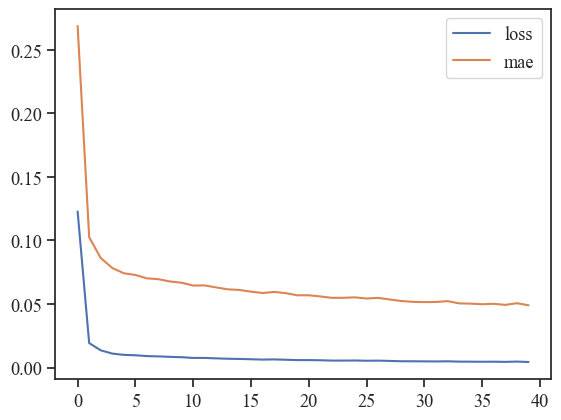

In [16]:
pd.DataFrame(model.history.history).plot()

In [34]:
# save the trained model
model.save('D:/DAS/models/cnn.h5')

In [158]:
# load the trained model
model = load_model('D:/DAS/models/cnn.h5')

In [17]:
# print the performance 
y_test_pred=model.predict(x1).flatten()
y_train_pred=model.predict(x0).flatten()

train_mse = mean_squared_error(y0, y_train_pred)
train_mae = mean_absolute_error(y0, y_train_pred)
train_r2 = r2_score(y0, y_train_pred)
train_pcc = pearsonr(y0, y_train_pred)[0]

test_mse = mean_squared_error(y1, y_test_pred)
test_mae = mean_absolute_error(y1, y_test_pred)
test_r2 = r2_score(y1, y_test_pred)
test_pcc = pearsonr(y1, y_test_pred)[0]  

print(f"trainset -- MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}, PCC: {train_pcc:.4f}")
print(f"testset -- MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}, PCC: {test_pcc:.4f}")

108/108 [==============================] - 0s 3ms/step
trainset -- MSE: 0.0038, MAE: 0.0461, R²: 0.9554, PCC: 0.9775
testset -- MSE: 0.0090, MAE: 0.0781, R²: 0.8079, PCC: 0.9100


In [129]:
# save test_results
np.savetxt("D:/DAS/model output/cnnlstm(new).txt", y_test_pred, fmt="%.10f")

27/27 [==============================] - 0s 3ms/step


## Missing data inversing

### Missing data segment in January

In [43]:
no_label_feature = feature1.iloc[972:1261, 1:]

In [44]:
n = no_label_feature.shape[0]
X_list = []
for i in range(n - window + 1):
    X_win = no_label_feature[i:i + window]
    X_list.append(X_win)
    
X = np.array(X_list)

In [45]:
X_2d = X.reshape(-1, n_feat)

In [46]:
for i in range(n_feat):
    X_2d[:, i:i+1] = scalers[i].transform(X_2d[:, i:i+1])

x = X_2d.reshape(X.shape)

In [47]:
no_label = model.predict(x)

9/9 [==============================] - 0s 2ms/step


In [48]:
time1 = pd.date_range(start='2024-01-13 00:01:01', end='2024-2-14 10:31:01', freq='30min')

In [50]:
all = np.concatenate([label1_1[0:], no_label.reshape(-1), label1_2[:]], axis=0)
all = pd.DataFrame(all, index=time1)

### Missing data segment in July

In [91]:
insert_row = np.full((1, 198), np.nan)
no_label_feature2 = np.concatenate([feature4.iloc[186:, 1:].values, insert_row, feature5.iloc[:3, 1:].values])

In [100]:
no_label_feature2[198:208] = np.nan
no_label_feature2 = pd.DataFrame(no_label_feature2).interpolate(
    method='cubic',  # 线性插值
    axis=0,          # 按列插值
    )

In [101]:
n = no_label_feature2.shape[0]
X_list2 = []
for i in range(n - window + 1):
    X_win = no_label_feature2[i:i + window]
    X_list2.append(X_win)
    
X2 = np.array(X_list2)


In [102]:
X2_2d = X2.reshape(-1, n_feat)
for i in range(n_feat):
    X2_2d[:, i:i+1] = scalers[i].transform(X2_2d[:, i:i+1])

x2 = X2_2d.reshape(X2.shape)

In [103]:
no_label2 = model.predict(x2)

12/12 [==============================] - 0s 1ms/step


In [105]:
time2 = pd.date_range(start='2024/7/22 11:01:01', end='2024-08-27 12:31:01', freq='30min')

In [110]:
all2 = np.concatenate([label4[:], no_label2.reshape(-1), label5[1:]], axis=0)
all2 = pd.DataFrame(all2, index=time2)

### Visualization of results

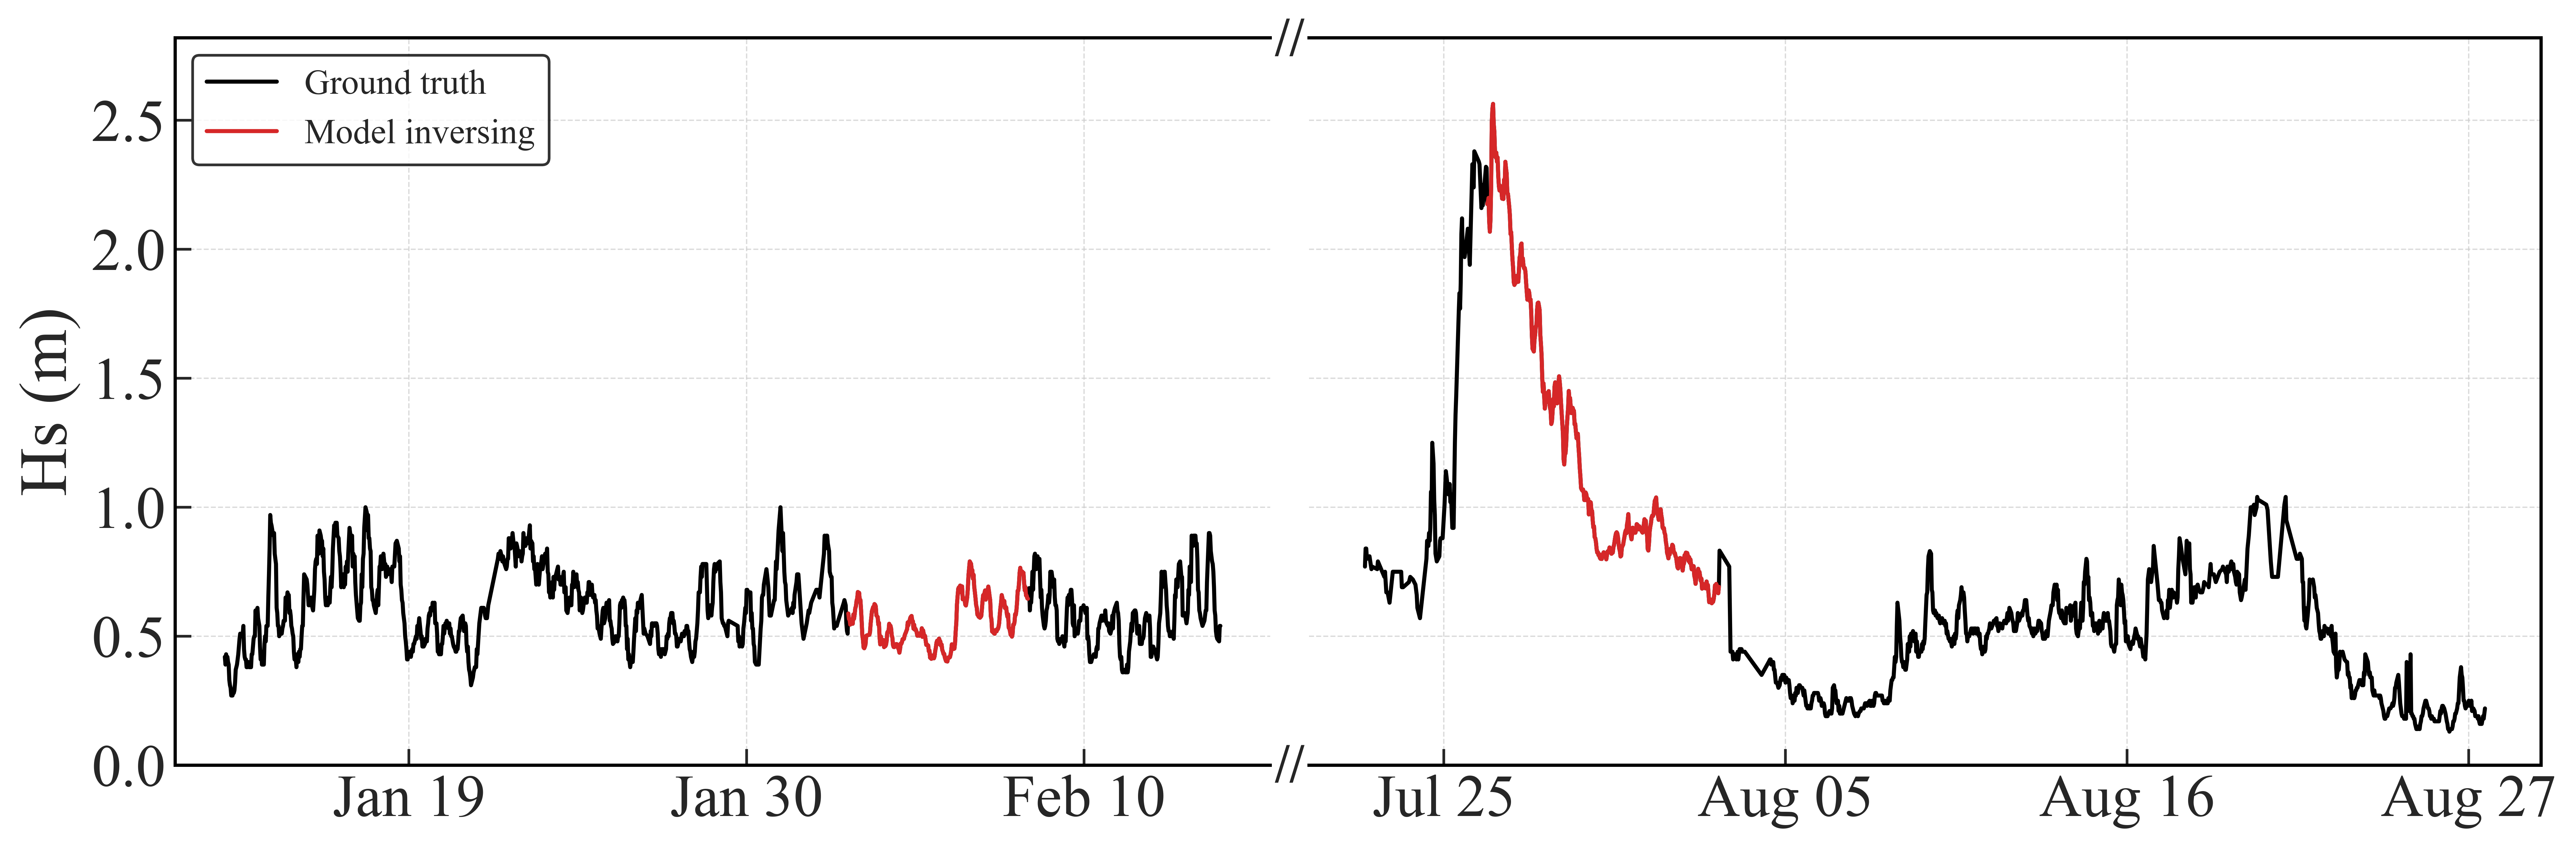

In [172]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Assume you already have the following variables:
# all, all2 are pandas.Series with datetime index
# no_label and no_label2 are model outputs

# === Time ratio calculation ===
x1 = all.index
x2 = all2.index
duration1 = (x1[-1] - x1[0]).days
duration2 = (x2[-1] - x2[0]).days
total_duration = duration1 + duration2

width1 = 0.6 * duration1 / total_duration
width2 = 0.6 * duration2 / total_duration
left1 = 0.06
gap = 0.01
left2 = left1 + width1 + gap
bottom = 0.15
height = 0.75

fig = plt.figure(figsize=(20, 5), dpi=600)

# === First subplot ===
ax1 = fig.add_axes([left1, bottom, width1, height])
ax1.plot(all, label='Ground truth', color='black')
ax1.plot(all[975:1257], label='Model inversion', color='#d62728')
ax1.set_ylabel('Hs (m)', fontsize=25)
ax1.set_ylim(0, max(all.max().item(), all2.max().item()) * 1.1)
ax1.legend(loc='upper left', fontsize=13, frameon=True, facecolor='white', edgecolor='black')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(axis='both', direction='in', length=6, width=1, labelsize=22)
ax1.spines['right'].set_visible(False)

# === Second subplot ===
ax2 = fig.add_axes([left2, bottom, width2, height], sharey=ax1)
ax2.plot(all2, label='Ground truth', color='black')
ax2.plot(
    all2[len(label4[:]):len(label4[:]) + len(no_label2.reshape(-1))],
    label='Model inversion', color='#d62728'
)
# ax2.legend(loc='upper right', fontsize=13, frameon=True, facecolor='white', edgecolor='black')
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(axis='both', direction='in', length=6, width=1, labelsize=22)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='y', length=0)

# === Add broken-axis markers (two slashes //) - upper axis ===
fig.text(
    x=left1 + width1 + gap / 2,
    y=bottom + height - 0.03,
    s='//',
    fontsize=20,
    ha='center',
    va='bottom',
    fontweight='bold'
)

# === Add broken-axis markers (two slashes //) - lower axis ===
fig.text(
    x=left1 + width1 + gap / 2,
    y=bottom + 0.02,
    s='//',
    fontsize=20,
    ha='center',
    va='top',
    fontweight='bold'
)

from matplotlib.dates import DayLocator

# Set major ticks every 11 days for both axes
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=11))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=11))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# === Beautify borders and grid ===
for ax in [ax1, ax2]:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.show()


## The model inversing significant wave heights were validated against ERA5 reanalysis data

In [113]:
import xarray as xr

name = 'southsea.csv'
era5 = pd.read_csv(os.path.join(data_path, name), header=None)

In [114]:
era5.set_index(0, inplace=True) 

In [165]:
era5.index = pd.to_datetime(era5.index)

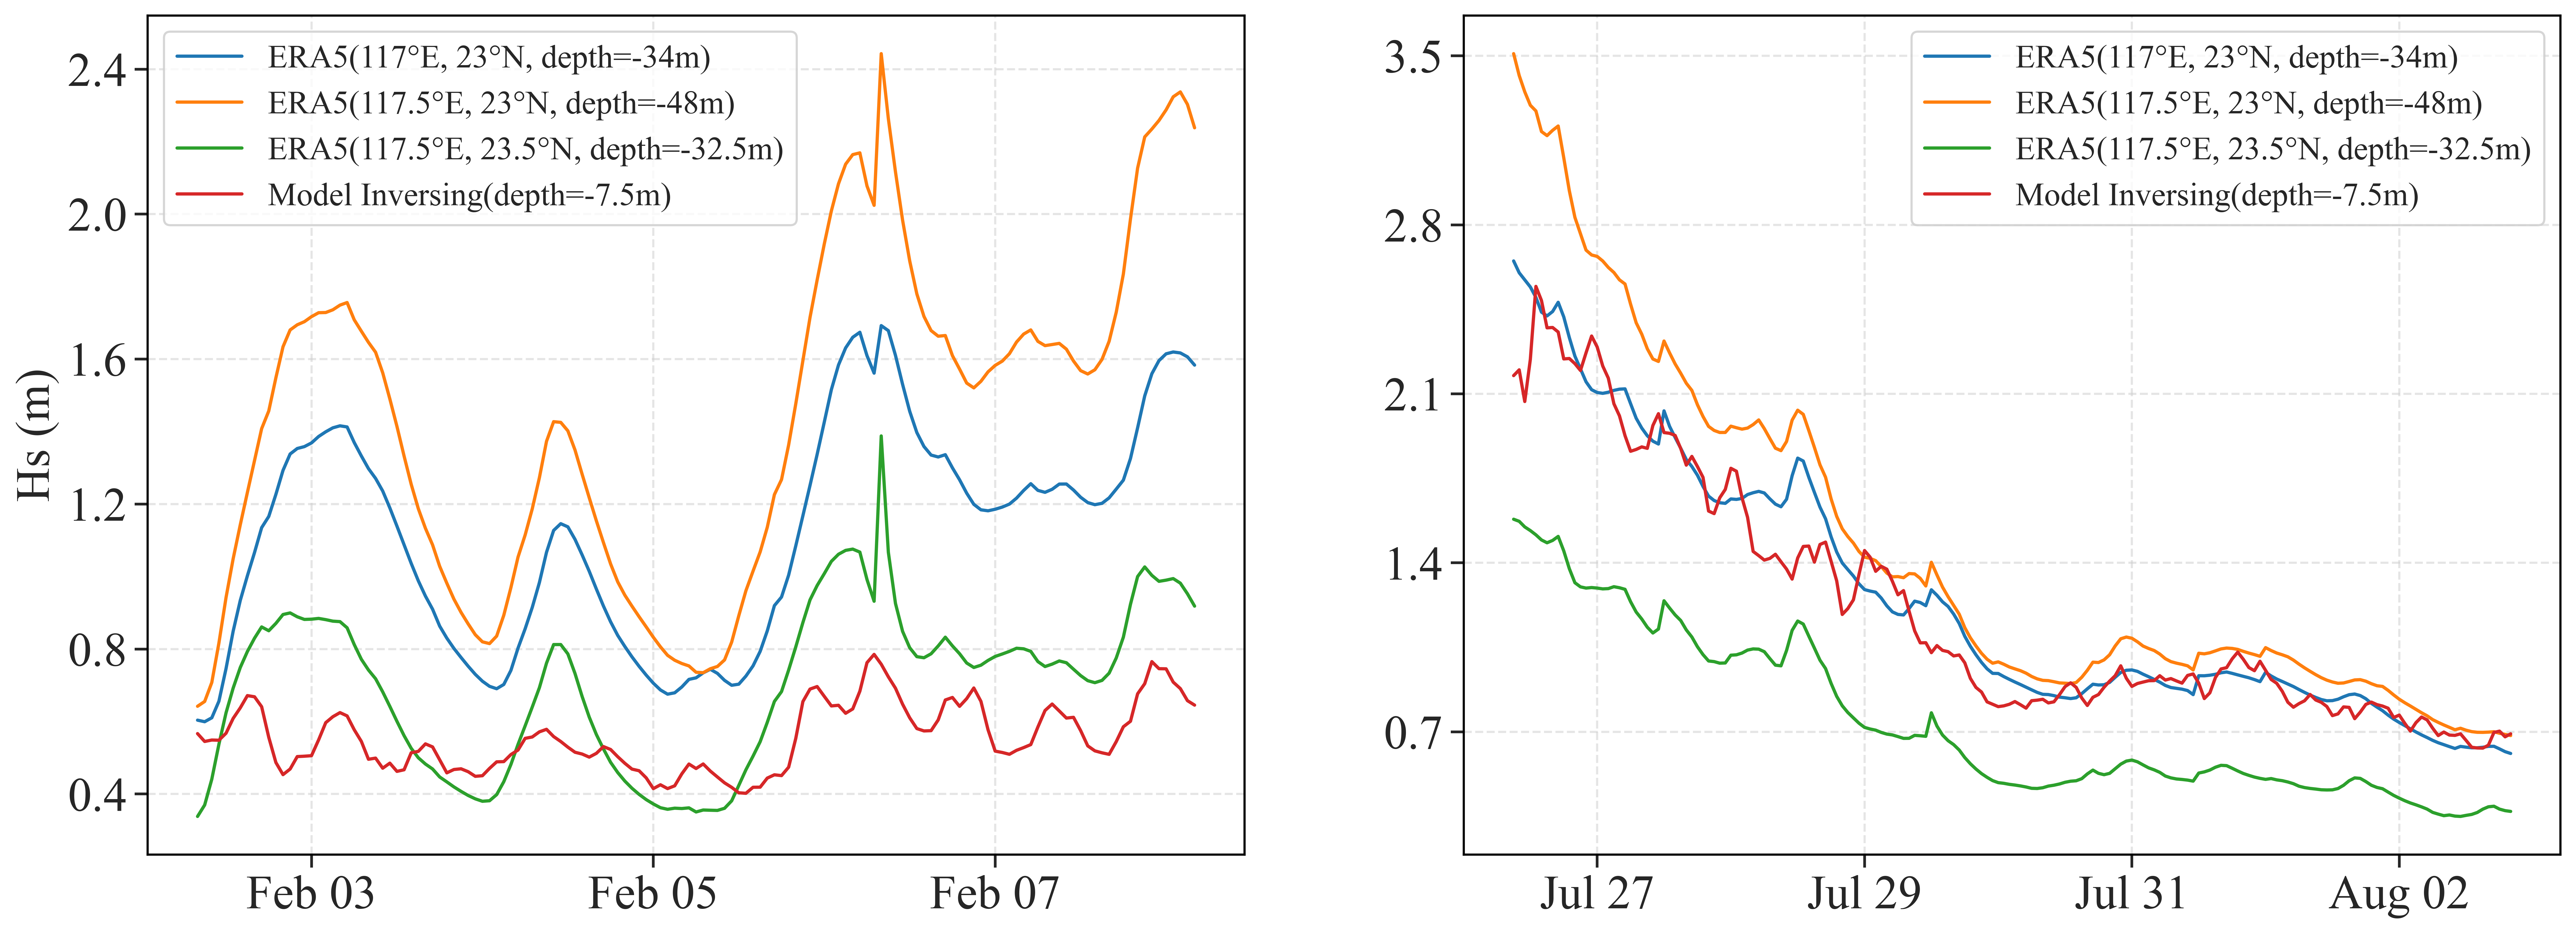

In [244]:

import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator  # 新增导入


# 创建画布和子图（1行2列）
fig = plt.figure(figsize=(20, 7), dpi=600)
gs = GridSpec(1, 2, width_ratios=[7, 7])  # 两个时间段都是7天，宽度比例1:1

# 左图：2月数据
ax1 = fig.add_subplot(gs[0])
feb_data = era5['2024/2/2  7:31:01':'2024-02-08 04:01:01']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax1.plot(feb_data[654], color=colors[0], label='ERA5(117°E, 23°N, depth=-34m)')
ax1.plot(feb_data[655], color=colors[1], label='ERA5(117.5°E, 23°N, depth=-48m)')
ax1.plot(feb_data[610], color=colors[2], label='ERA5(117.5°E, 23.5°N, depth=-32.5m)')

ax1.plot(feb_data.index, all[975:1257][1::2], label='Model Inversing(depth=-7.5m)', color='#d62728')

# 右图：7月数据
ax2 = fig.add_subplot(gs[1])
jul_data = era5['2024-07-26 08:01:01':'2024/8/2 20:01:01']

ax2.plot(jul_data[654], color=colors[0], label='ERA5(117°E, 23°N, depth=-34m)')
ax2.plot(jul_data[655], color=colors[1], label='ERA5(117.5°E, 23°N, depth=-48m)')
ax2.plot(jul_data[610], color=colors[2], label='ERA5(117.5°E, 23.5°N, depth=-32.5m)')

ax2.plot(jul_data.index, 
        all2[len(label4[:]):len(label4[:]) + len(no_label2.reshape(-1))][::2],
        label='Model Inversing(depth=-7.5m)', color='#d62728')

# 设置x轴刻度
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# 设置y轴刻度为每0.5一个刻度

ax1.yaxis.set_major_locator(MultipleLocator(0.4))  # 每0.5一个主刻度
ax2.yaxis.set_major_locator(MultipleLocator(0.7)) 

# 统一样式设置

ax1.legend(loc='upper left', fontsize=15)
ax1.set_ylabel('Hs (m)', fontsize=22)
ax1.tick_params(axis='both', labelsize=22)
ax1.grid(True, linestyle='--', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
ax2.legend(loc='upper right', fontsize=15)
ax2.tick_params(axis='both', labelsize=22)
ax2.grid(True, linestyle='--', alpha=0.5)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)


#plt.tight_layout()
plt.show()

In [138]:
from scipy.stats import pearsonr, spearmanr

In [193]:
site = [654, 655, 610]

In [194]:
pearson1 = []
pearson2 = []
spearman1 = []
spearman2 = []

for i in site:
    pearson_coef1, pearson_p1 = pearsonr(era5[i]['2024/2/2  7:31:01':'2024-02-08 04:01:01'], 
                                    all[975:1257][1::2].iloc[:,0])
    spearman_coef1, spearman_p1 = spearmanr(era5[i]['2024/2/2  7:31:01':'2024-02-08 04:01:01'], 
                                    all[975:1257][1::2].iloc[:,0])
    pearson1.append(pearson_coef1)
    spearman1.append(spearman_coef1)

    pearson_coef2, pearson_p2 = pearsonr(era5[i]['2024-07-26 08:01:01':'2024/8/2  20:01:01'], 
                                   all2[len(label4[:]):len(label4[:]) + len(no_label2.reshape(-1))][::2].iloc[:,0])
    spearman_coef2, spearman_p2 = spearmanr(era5[i]['2024-07-26 08:01:01':'2024/8/2  20:01:01'], 
                                   all2[len(label4[:]):len(label4[:]) + len(no_label2.reshape(-1))][::2].iloc[:,0])
    pearson2.append(pearson_coef2)
    spearman2.append(spearman_coef2)


In [196]:
pearson1, spearman1, pearson2,  spearman2

([0.7425214068848331, 0.7527205341621468, 0.7708617723074868],
 [0.7185324714242904, 0.7208527762318592, 0.7593646988312855],
 [0.9741707047911351, 0.976005546747849, 0.9719129925594179],
 [0.957278516826651, 0.9714188709528071, 0.9662582178462298])